In [2]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2 
from tqdm import tqdm
import random

import warnings
warnings.filterwarnings("ignore")


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers

import numpy as np
import collections
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import LearningRateSchedule


In [4]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available: 2


# Load the Data



https://www.kaggle.com/datasets/orvile/gastric-cancer-histopathology-tissue-image-dataset

This dataset comprises 31,096 non-overlapping images, each with a size of 224x224 pixels. These images were extracted from H&E-stained pathological slides of human gastric cancer obtained from Harbin Medical University Cancer Hospital.

The dataset focuses on the tumor microenvironment (TME) and includes images categorized into eight distinct tissue types:

ADI: Adipose (fat tissue)
DEB: Debris (cellular waste) 
LYM: Lymphocytes (immune cells)
MUC: Mucus (protective secretion)
MUS: Smooth Muscle (muscle tissue)
NOR : Normal Colon Mucosa
STR: Cancer-associated Stroma (connective tissue around the tumor)
TUM: Tumor (cancerous tissue) 



In [5]:
path = "/kaggle/input/gastric-cancer-histopathology-tissue-image-dataset/HMU-GC-HE-30K/all_image"
tissue_types = os.listdir(path)
tissue_types.sort()
tissue_types

['ADI', 'DEB', 'LYM', 'MUC', 'MUS', 'NOR', 'STR', 'TUM']

Lets plot some images for each tissue types

ADI


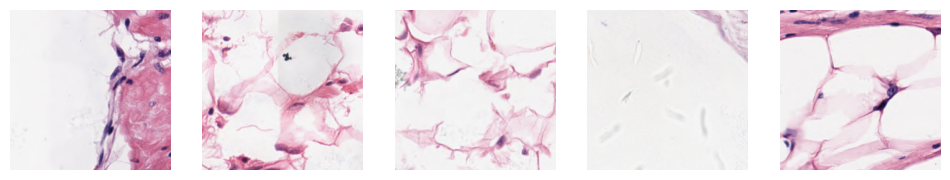

DEB


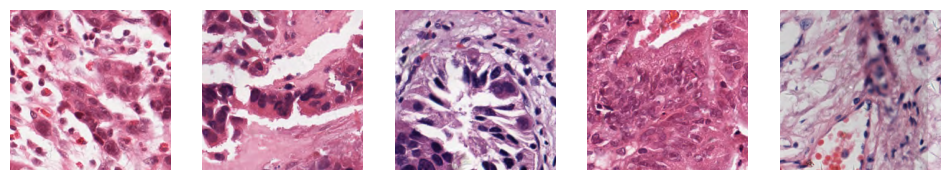

LYM


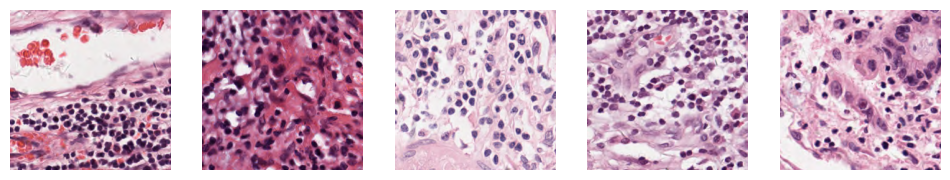

MUC


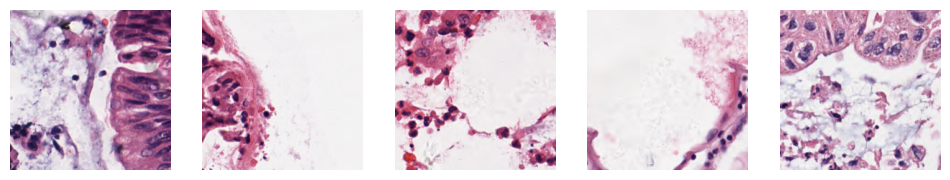

MUS


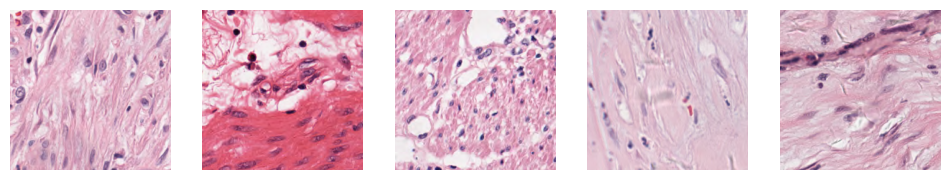

NOR


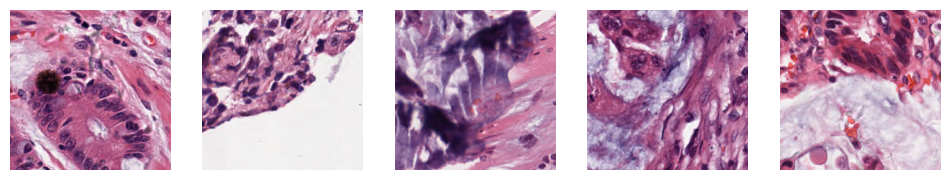

STR


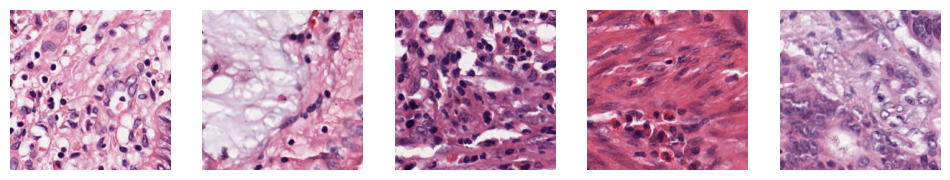

TUM


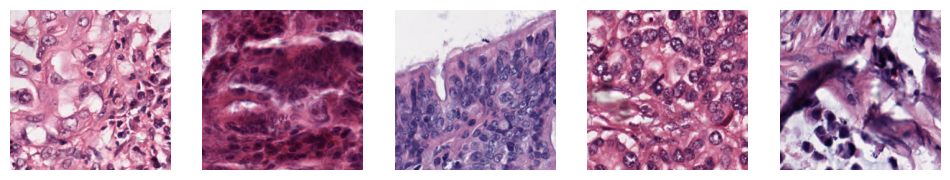

In [7]:
images_per_label = 5
for tissue in tissue_types:
    folder_path = os.path.join(path, tissue)
    folder_files = os.listdir(folder_path)
    random_ind=np.random.randint(0, len(folder_files),images_per_label)
    fig, ax = plt.subplots(1, images_per_label, figsize=(12, 10))
    print(tissue)
    for i, ind in enumerate(random_ind):     
        img = plt.imread(folder_path+'/'+folder_files[ind])
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()



Lets look at how many images we have for each tissue type

In [8]:
for tissue in tissue_types:
    folder_path = os.path.join(path, tissue)
    if os.path.isdir(folder_path):
        num_images = len([f for f in os.listdir(folder_path)])
        print(f"{tissue}: {num_images} images")

ADI: 3887 images
DEB: 3887 images
LYM: 3887 images
MUC: 3887 images
MUS: 3887 images
NOR: 3887 images
STR: 3887 images
TUM: 3887 images


# Create a train and validation dataset

In [10]:
# 85-15 split 

train_ds,val_ds = tf.keras.utils.image_dataset_from_directory(
  path,
  labels='inferred',
  validation_split=0.15,
  subset='both',
  seed=85,
  batch_size=32,
  image_size=(224, 224),
  shuffle=True
  )


Found 31096 files belonging to 8 classes.
Using 26432 files for training.
Using 4664 files for validation.


I0000 00:00:1752222390.547990      77 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1752222390.548698      77 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5




To make sure we have the datasets as intended we can visualize the class names.


In [11]:
train_ds.class_names

['ADI', 'DEB', 'LYM', 'MUC', 'MUS', 'NOR', 'STR', 'TUM']



We can also fetch one batch of images and labels in the train dataset and look at the shape.


In [12]:
image, label = next(iter(train_ds))
print(image.shape)
print(label.shape)

(32, 224, 224, 3)
(32,)




Look at the class distribution to see if there is any imbalance.


In [13]:
train_labels = []
for _, labels in train_ds:
    train_labels.extend(labels.numpy())

train_label_counts = collections.Counter(train_labels)
print("Train label distribution:")
print(dict(sorted(train_label_counts.items())))

val_labels = []
for _, labels in val_ds:
    val_labels.extend(labels.numpy())

val_label_counts = collections.Counter(val_labels)
print("\nValidation label distribution:")
print(dict(sorted(val_label_counts.items())))

Train label distribution:
{0: 3330, 1: 3298, 2: 3316, 3: 3316, 4: 3277, 5: 3306, 6: 3312, 7: 3277}

Validation label distribution:
{0: 557, 1: 589, 2: 571, 3: 571, 4: 610, 5: 581, 6: 575, 7: 610}


The sample distributions look reasonably balanced across train and validation sets which is good.

Now preprocess the data:

In [14]:
def preprocess(image, label):
    image = tf.keras.applications.efficientnet.preprocess_input(image)
    return image, label


In [15]:
train_ds_clean = train_ds.map(preprocess).prefetch(tf.data.AUTOTUNE)
val_ds_clean = val_ds.map(preprocess).prefetch(tf.data.AUTOTUNE)


In [16]:
# save the number of class labels
num_labels=len(train_ds.class_names)

We use the pretrained mode EfficientNetB3 for training the dataset.

In [40]:
from tensorflow.keras.applications import EfficientNetB0,Xception,EfficientNetB1,EfficientNetB3

input_tensor = tf.keras.Input(shape=(224, 224, 3))
base_model = tf.keras.applications.EfficientNetB3(weights="imagenet", include_top=False, input_tensor=input_tensor)
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(8, activation="softmax")(x)
model = tf.keras.Model(inputs=input_tensor, outputs=output)


In [41]:
for layer in base_model.layers:
    layer.trainable = True
#for layer in base_model.layers[-60:]:
   # layer.trainable = True



Set up an early stopping condition and save the best model with minimum validation loss as the metric:


In [42]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

early_stopping = tf.keras.callbacks.EarlyStopping(
    min_delta=0.005, # minimium amount of change to count as an improvement
    patience=4, # how many epochs to wait before stopping
    restore_best_weights=True
)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    "/kaggle/working/efficientnetb3_baseline.h5",
    save_best_only=True,
    monitor="val_loss",
    mode="min"
)
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',     
    factor=0.3,             
    patience=3,            
    verbose=1,              
    min_lr=1e-6           
)



Define the opimizer, compile the model and run:


In [43]:
optimizer = tf.keras.optimizers.SGD(learning_rate=3e-4, momentum=0.9)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])
history = model.fit(train_ds_clean, epochs=16, validation_data=val_ds_clean, callbacks=[early_stopping, checkpoint_callback,lr_scheduler])

Epoch 1/16
826/826 ━━━━━━━━━━━━━━━━━━━━ 317s 275ms/step - accuracy: 0.3087 - loss: 1.8385 - val_accuracy: 0.5575 - val_loss: 1.2429 - learning_rate: 3.0000e-04
Epoch 2/16
826/826 ━━━━━━━━━━━━━━━━━━━━ 217s 262ms/step - accuracy: 0.5592 - loss: 1.1988 - val_accuracy: 0.6199 - val_loss: 1.0340 - learning_rate: 3.0000e-04
Epoch 3/16
826/826 ━━━━━━━━━━━━━━━━━━━━ 219s 265ms/step - accuracy: 0.6171 - loss: 1.0322 - val_accuracy: 0.6531 - val_loss: 0.9459 - learning_rate: 3.0000e-04
Epoch 4/16
826/826 ━━━━━━━━━━━━━━━━━━━━ 220s 266ms/step - accuracy: 0.6446 - loss: 0.9491 - val_accuracy: 0.6683 - val_loss: 0.8945 - learning_rate: 3.0000e-04
Epoch 5/16
826/826 ━━━━━━━━━━━━━━━━━━━━ 220s 266ms/step - accuracy: 0.6690 - loss: 0.8901 - val_accuracy: 0.6769 - val_loss: 0.8615 - learning_rate: 3.0000e-04
Epoch 6/16
826/826 ━━━━━━━━━━━━━━━━━━━━ 220s 266ms/step - accuracy: 0.6928 - loss: 0.8263 - val_accuracy: 0.6880 - val_loss: 0.8343 - learning_rate: 3.0000e-04
Epoch 7/16
826/826 ━━━━━━━━━━━━━━━━━━━━ 

In [46]:
from tensorflow.keras.models import load_model

best_model = load_model("/kaggle/working/efficientnetb3_baseline.h5")
loss, acc = best_model.evaluate(val_ds_clean, verbose=0)
print(f"Saved model - val_loss: {loss:.4f}, val_accuracy: {acc:.4f}")

Saved model - val_loss: 0.7523, val_accuracy: 0.7236


Validation loss started to diverge after this, when I tried to run this for few more epochs. We have acheived a validation accuracy of 72.3% for 8 classes which is a good baseline actually.

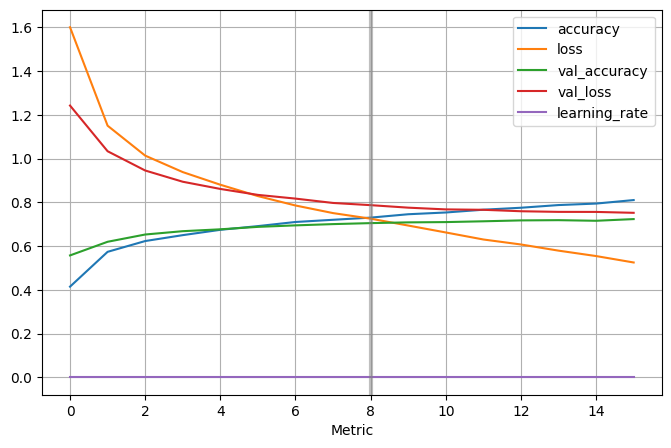

In [44]:
pd.DataFrame(history.history).plot(figsize=(8, 5)) 
plt.axvline(8,lw=3,color='grey',alpha=0.5)
plt.grid(True)
plt.xlabel("Epoch-1")
plt.xlabel("Metric")
plt.show()

Lets look at various metrics to see how the model performed.

AUC score:

In [47]:
from sklearn.metrics import roc_auc_score

y_pred_probs = best_model.predict(val_ds)
y_true = np.concatenate([y for x, y in val_ds], axis=0)

# Compute AUC
auc = roc_auc_score(y_true, y_pred_probs, multi_class='ovr')
print(f"AUC: {auc:.4f}")

146/146 ━━━━━━━━━━━━━━━━━━━━ 28s 140ms/step
AUC: 0.9579


Confusion metrics:

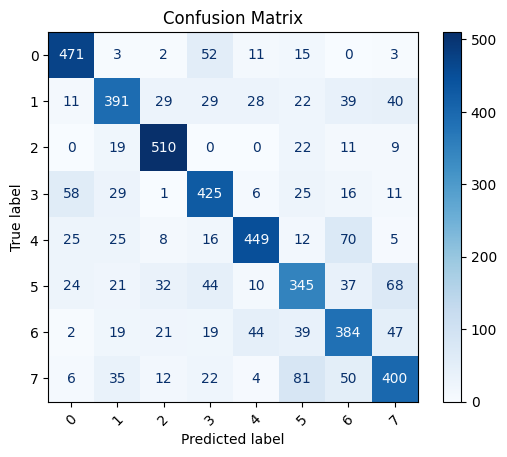

In [49]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
y_pred = np.argmax(y_pred_probs, axis=1)
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

In [50]:
from sklearn.metrics import classification_report
report = classification_report(y_true, y_pred, digits=4)
print(report)

              precision    recall  f1-score   support

           0     0.7889    0.8456    0.8163       557
           1     0.7214    0.6638    0.6914       589
           2     0.8293    0.8932    0.8600       571
           3     0.7002    0.7443    0.7216       571
           4     0.8134    0.7361    0.7728       610
           5     0.6150    0.5938    0.6042       581
           6     0.6326    0.6678    0.6497       575
           7     0.6861    0.6557    0.6706       610

    accuracy                         0.7236      4664
   macro avg     0.7234    0.7250    0.7233      4664
weighted avg     0.7233    0.7236    0.7226      4664



With the baseline EfficientNetB3, we have acheived the following metrics:

    Accuracy: 72.36% — good baseline, especially with 8 classes.

    Macro F1-score: 0.7233 — well-balanced performance across classes.

    AUC: 0.9579 — strong class separability.

From the confusion matrix:

Class 0 (471), Class 2 (510), Class 4 (449) are well-predicted.
    
    Class 7 largely confused with class 5 (81).
    Class 6 largely confused with Class 4 (44) and class 7 (47).
    Class 5 largely confused with class 7 (68).
    Class 4 largely confused with class 6 (70).
    Class 3 largely confused with class 0 (58).
    Class 2 largely confused with class 1 (19).
    Class 1 largely confused with class 6 (39) and class 7 (40).
    Class 0 largely confused with class 3 (50).

Class 5 and Class 7 are getting confused with each other. Looking at which tissue types these are, we can see that Class 5 is Normal colon mucosa aka healthy tissue. Class 7 is actually the tumor. Which means this confusion needs immediate attention, since this has direct clinical significance.